Epoch 1/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.3189 - loss: 1.8012 - val_accuracy: 0.4718 - val_loss: 1.3603
Epoch 2/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4730 - loss: 1.3237 - val_accuracy: 0.5118 - val_loss: 1.2302
Epoch 3/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5224 - loss: 1.1968 - val_accuracy: 0.5564 - val_loss: 1.1235
Epoch 4/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5613 - loss: 1.1140 - val_accuracy: 0.6002 - val_loss: 1.0450
Epoch 5/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5916 - loss: 1.0444 - val_accuracy: 0.6014 - val_loss: 1.0389
Epoch 6/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6163 - loss: 0.9991 - val_accuracy: 0.6287 - val_loss: 0.9549
Epoch 7/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6323 - loss: 0.9563 - val_accuracy: 0.6341 - val_loss: 0.9479
Epoch 8/35
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6513 -

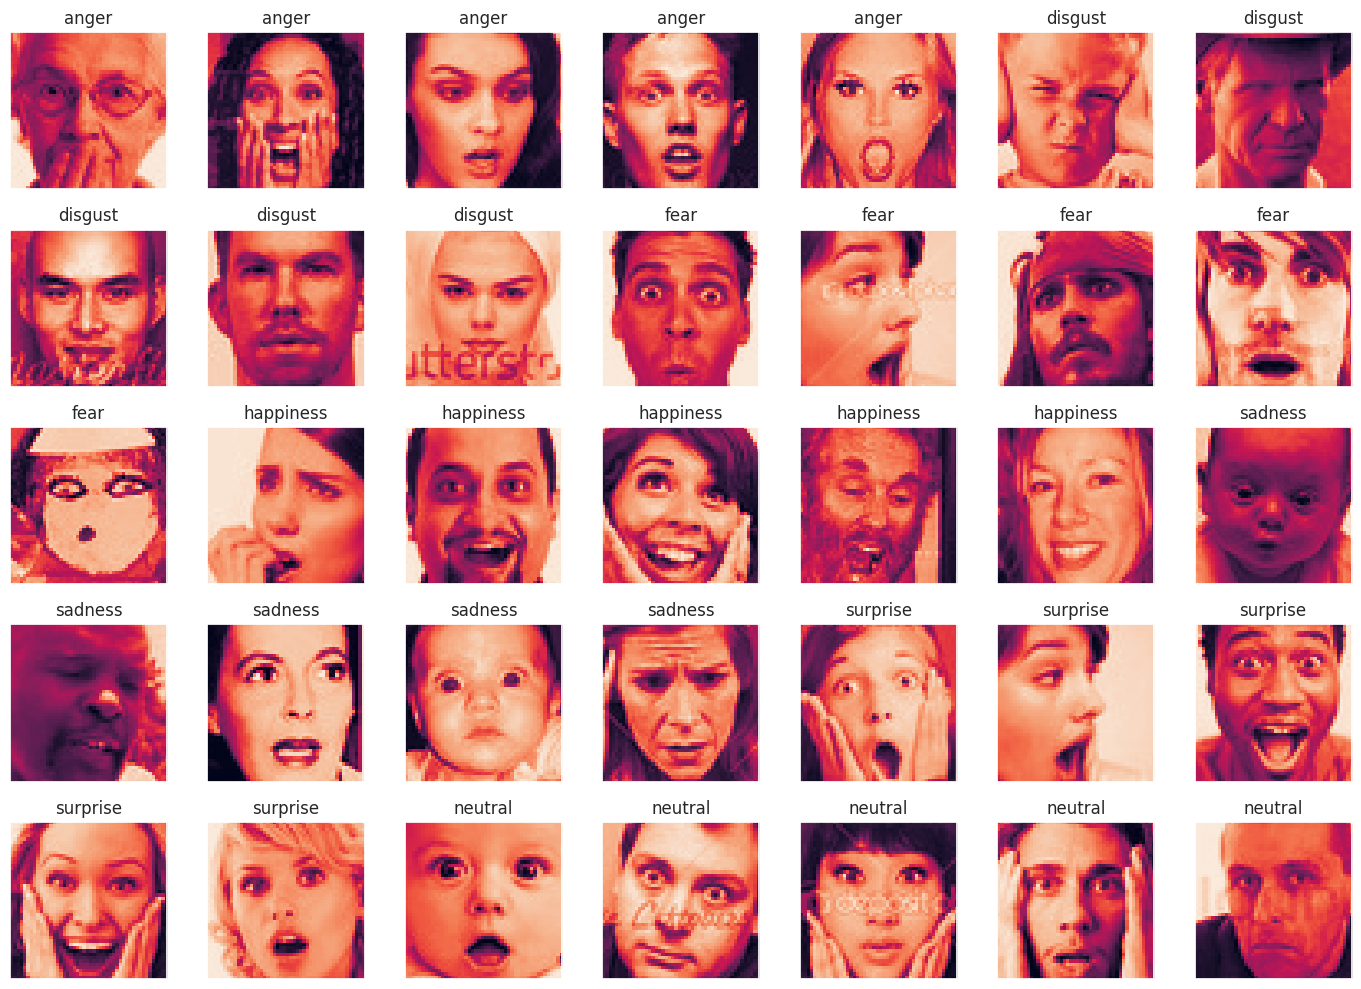

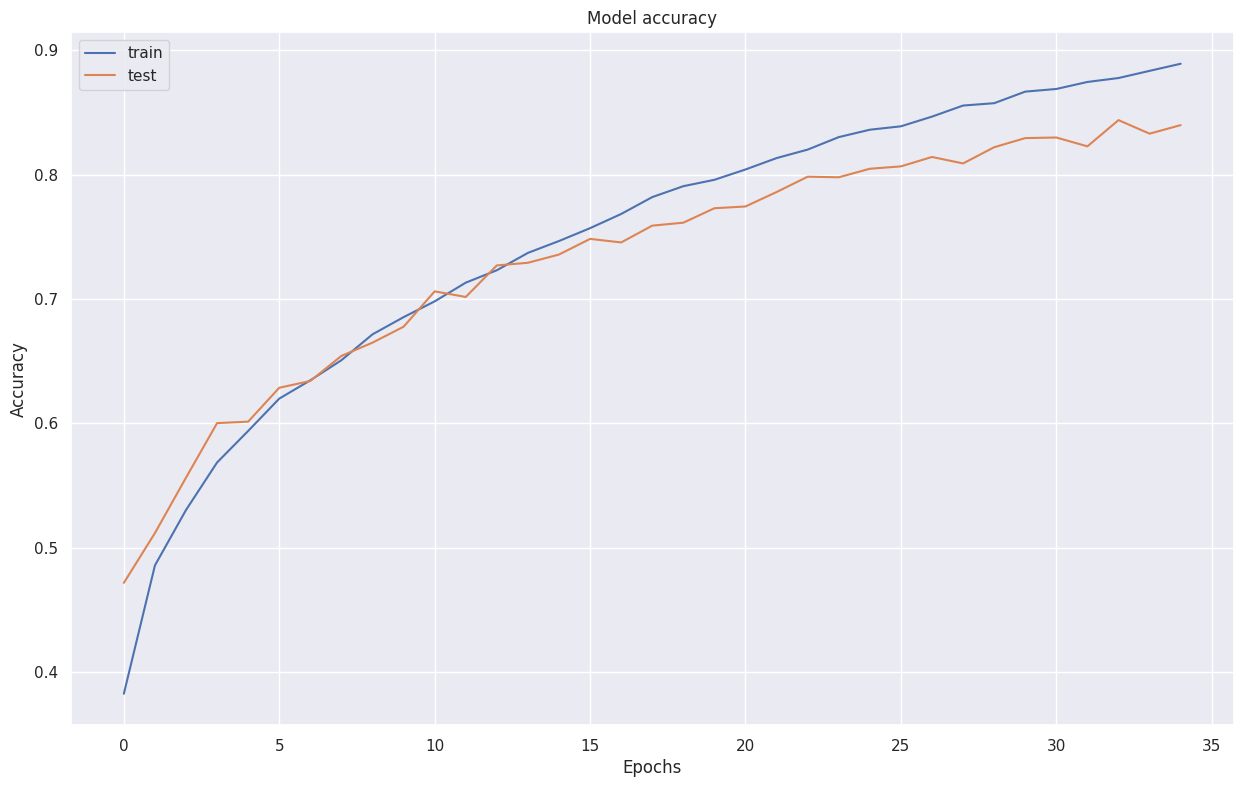

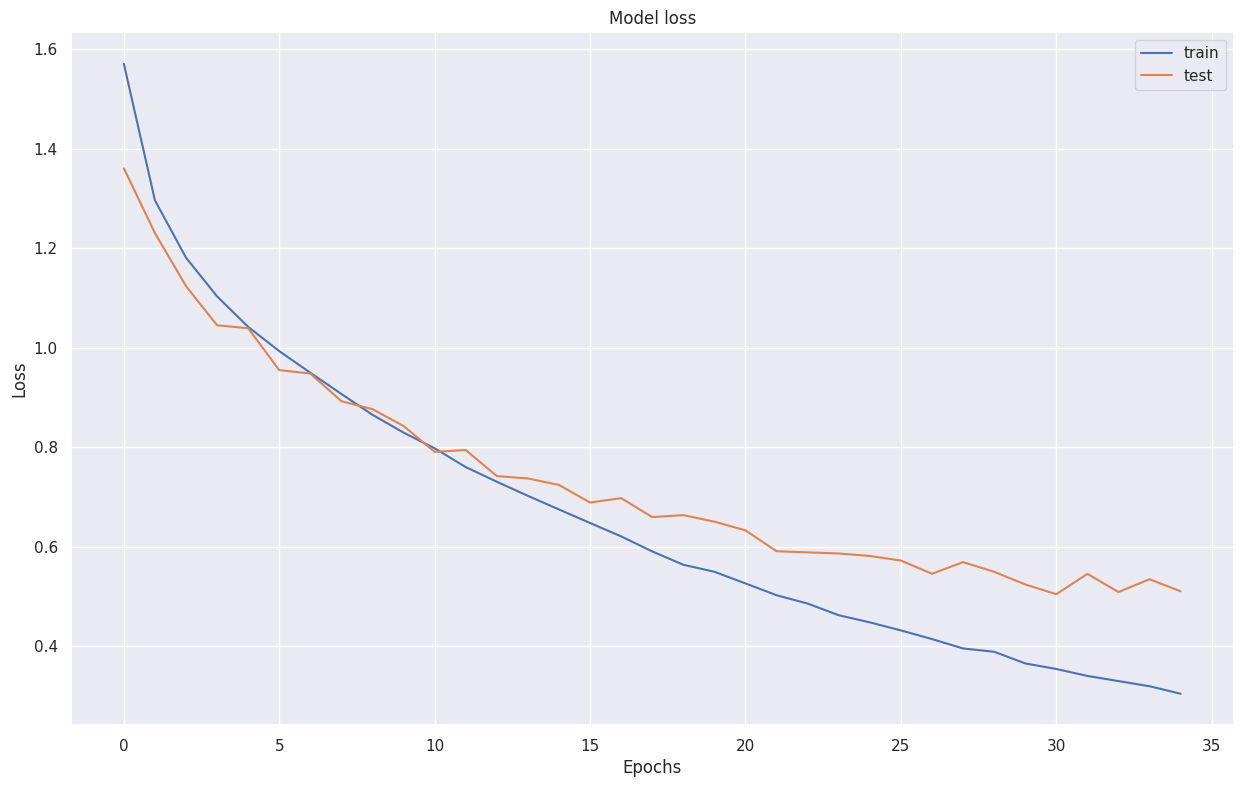

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       598
           1       1.00      1.00      1.00       572
           2       0.90      0.94      0.92       619
           3       0.77      0.79      0.78       600
           4       0.86      0.78      0.82       632
           5       0.90      0.98      0.94       568
           6       0.63      0.68      0.65       631

    accuracy                           0.84      4220
   macro avg       0.84      0.84      0.84      4220
weighted avg       0.84      0.84      0.84      4220



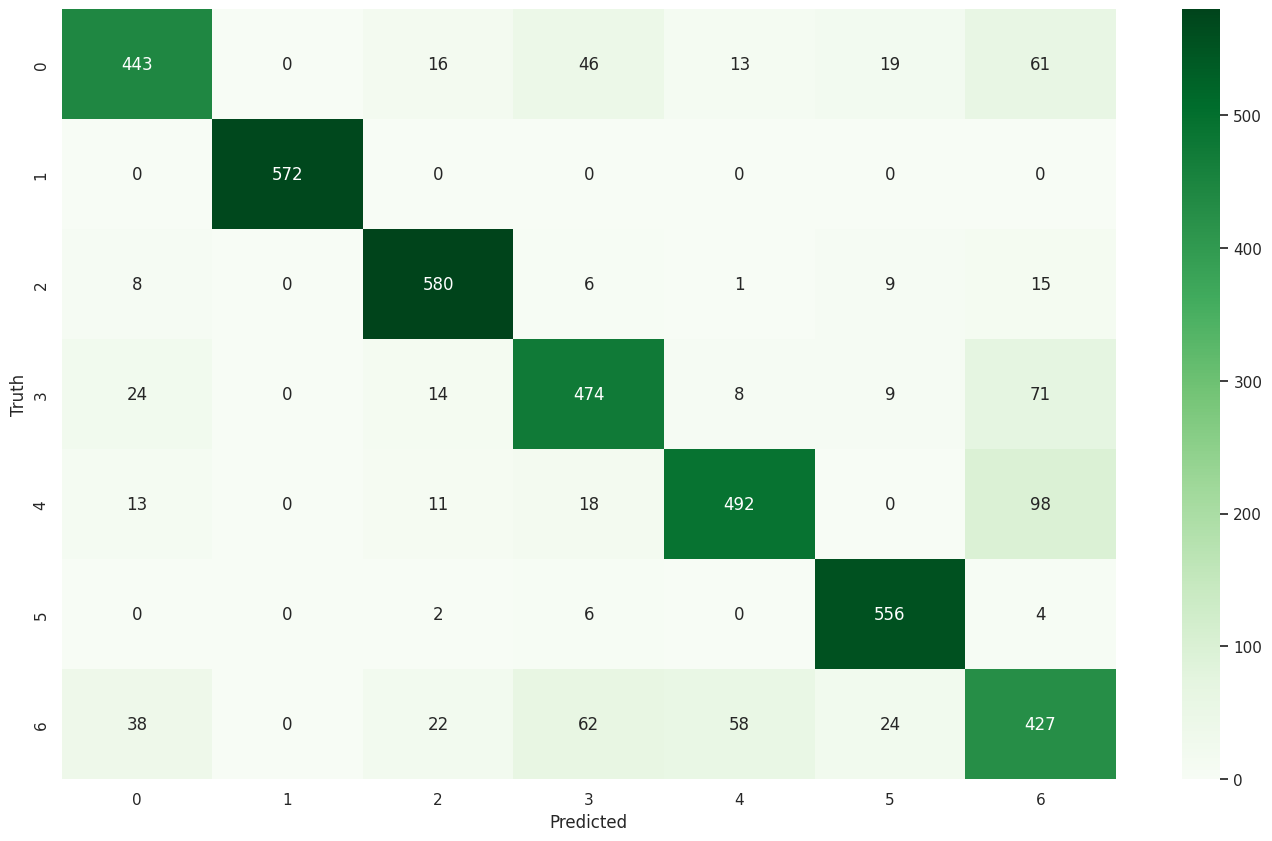

ValueError: The filename must end in `.weights.h5`. Received: filepath=/content/fer.h5

In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

# Reading Dataset
data = pd.read_csv('/content/fer2013.csv')

# Label mapping
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5:'surprise', 6:'neutral'}

# Plot few sample images
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

# Split data into features & labels
x_data = data['pixels']
y_data = data['emotion']

# Random Over Sampling to balance dataset
oversampler = RandomOverSampler(sampling_strategy='auto')
x_data_res, y_data_res = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)

# Flatten x_data back to series
x_data_res = pd.Series(x_data_res.flatten())
y_data_res = y_data_res[:len(x_data_res)]  # Match labels to pixels

# Safe pixel parsing
x_data_list = [np.fromstring(p, sep=' ', dtype=np.float32) for p in x_data_res]
x_data_list = [arr for arr in x_data_list if arr.size == 48*48]

x_data = np.stack(x_data_list)/255.0
x_data = x_data.reshape(-1,48,48,1)

y_data = np.array(y_data_res[:len(x_data)])
y_data = to_categorical(y_data, 7)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=45)

# CNN Model
model = Sequential([
    Input((48,48,1)),
    Conv2D(32,(3,3),strides=(1,1),padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    Conv2D(64,(3,3),strides=(1,1),padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(64,(3,3),strides=(1,1),padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    Conv2D(128,(3,3),strides=(1,1),padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(128,(3,3),strides=(1,1),padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(250,activation='relu'),
    Dropout(0.5),
    Dense(7,activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(x_train, y_train, epochs=35, validation_data=(x_test, y_test))

# Evaluate
print("Test Accuracy:", model.evaluate(x_test, y_test)[1]*100, "%")
print("Test Loss:", model.evaluate(x_test, y_test)[0])

# Plot accuracy
plt.figure(figsize=(15, 9))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Plot loss
plt.figure(figsize=(15, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Predictions & Classification Report
y_pred = model.predict(x_test)
y_result = np.argmax(y_pred,axis=1)
y_actual = np.argmax(y_test,axis=1)

print(classification_report(y_actual, y_result))

cm = tf.math.confusion_matrix(y_actual, y_result)
plt.figure(figsize=(17,10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Save model
model.save("/content/Facial_Expression_Detection_System.hdf5")
fer_json = model.to_json()
with open("/content/Facial_Expression_Recognition.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("/content/fer.h5")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')